# Introduction
This tutorial illustrates how to study the cost and effect by varying system parameters in OpenDss through Python. we will use a 3-phase 2-bus example as shown below. We will study the effect of (1)power rating of loads, (2) unbalanced loads, (3) PV system installation.   

In [2]:
import os
import pandas as pd;
import numpy as np
import opendssdirect as dss
import matplotlib as plt
os.chdir('C:\\Users\\TAM048\\Desktop\\Opendss\\Jupyter project\\Tutorial 3 changing parameter on 2_bus system') 
dss.Basic.AllowEditor(False)

### (1) Effects of power rating

,Bus,BasekV,Node1,Magnitude1,Angle1,pu1,Node2,Magnitude2,Angle2,pu2,Node3,Magnitude3,Angle3,pu3,Node4,Magnitude4,Angle4,pu4
0,B1,0,1,230.940,0.0,0,2,230.940,-120.0,0,3,230.940,120.0,0,4,0.00000,0.0,0
1,B2,0,1,217.551,-2.1,0,2,220.825,-122.2,0,3,220.779,117.4,0,4,3.22204,21.9,0


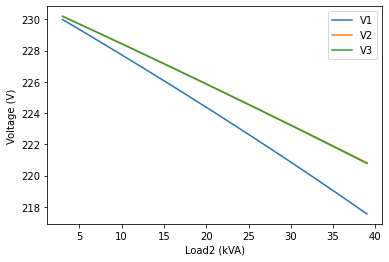

In [3]:
df=pd.DataFrame(columns=['kVA_Load','V1','V2','V3']);

for kVA_Loads in range(3,40,3): #increment kVA rating of load2 by 3kVA
    dss.run_command('Redirect two_buses_balanced.dss')
    
    #change the load
    dss.run_command('Load.LoadP1.kVA='+str(kVA_Loads))
    dss.run_command('Load.LoadP2.kVA='+str(kVA_Loads))
    dss.run_command('Load.LoadP3.kVA='+str(kVA_Loads))
    
    dss.run_command('Solve')
    dss.run_command('Export Voltages original.csv')

    Voltages_data=pd.read_csv("original.csv",header=0);
    V_Bus2=Voltages_data[Voltages_data['Bus']=='B2'];

    V1=V_Bus2[' Magnitude1'][1];
    V2=V_Bus2[' Magnitude2'][1];
    V3=V_Bus2[' Magnitude3'][1];



    result={'kVA_Load':kVA_Loads ,'V1':V1 ,'V2':V2 ,'V3': V3 };
    df=df.append(result,ignore_index=True);

df.plot(x='kVA_Load',y=['V1','V2','V3'],ylabel='Voltage (V)',xlabel=('Load2 (kVA)'))
Voltages_data

### (2) Effects of unbalanced loads

<AxesSubplot:xlabel='Load2 (kVA)', ylabel='Voltage (V)'>

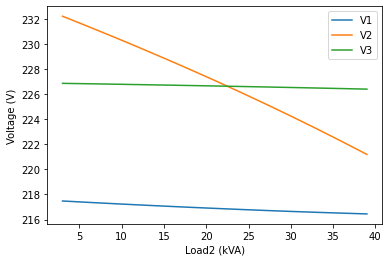

In [4]:
df=pd.DataFrame(columns=['kVA_Load2','V1','V2','V3']);

for kVA_Load2 in range(3,40,3): #increment kVA rating of load2 by 3kVA
    dss.run_command('Redirect two_buses_unbalanced.dss')
    
    #change the load
    dss.run_command('Load.LoadP2.kVA='+str(kVA_Load2))
  
    dss.run_command('Solve')
    dss.run_command('Export Voltages original.csv')

    Voltages_data=pd.read_csv("original.csv",header=0);
    V_Bus2=Voltages_data[Voltages_data['Bus']=='B2'];
    
    VN=V_Bus2[' Magnitude4'][1];

    V1=V_Bus2[' Magnitude1'][1]-VN;
    V2=V_Bus2[' Magnitude2'][1]-VN;
    V3=V_Bus2[' Magnitude3'][1]-VN;
    
    result={'kVA_Load2':kVA_Load2 ,'V1':V1 ,'V2':V2 ,'V3': V3 };
    df=df.append(result,ignore_index=True);

df.plot(x='kVA_Load2',y=['V1','V2','V3'],ylabel='Voltage (V)',xlabel='Load2 (kVA)')


### (3) Effects of PV system installation

#### study of PV system capacity

<AxesSubplot:xlabel='Pmpp (kW)', ylabel='Voltage (V)'>

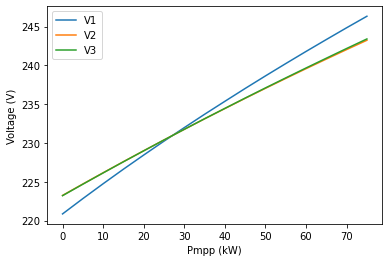

In [6]:
df=pd.DataFrame(columns=['Pmpp','V1','V2','V3']);

for Pmpp in range(0,80,5): #increment kVA rating of load2 by 3kVA
    dss.run_command('Redirect two_buses_balanced_PV.dss')
    
    #change the PV size
    kVA_rating=round(Pmpp/0.9,1);
    
    dss.run_command('PVSystem.PV1.Pmpp='+str(Pmpp));
    dss.run_command('PVSystem.PV2.Pmpp='+str(Pmpp));
    dss.run_command('PVSystem.PV3.Pmpp='+str(Pmpp));
    dss.run_command('PVSystem.PV1.kVA='+str(kVA_rating));
    dss.run_command('PVSystem.PV2.kVA='+str(kVA_rating));
    dss.run_command('PVSystem.PV3.kVA='+str(kVA_rating));  

    dss.run_command('Solve')
    dss.run_command('Export Voltages balaced_PV.csv')

    Voltages_data=pd.read_csv("balaced_PV.csv",header=0);
    V_Bus2=Voltages_data[Voltages_data['Bus']=='B2'];

    V1=V_Bus2[' Magnitude1'][1];
    V2=V_Bus2[' Magnitude2'][1];
    V3=V_Bus2[' Magnitude3'][1];
    
    result={'Pmpp':Pmpp ,'V1':V1 ,'V2':V2 ,'V3': V3 };
    df=df.append(result,ignore_index=True);

df.plot(x='Pmpp',y=['V1','V2','V3'],ylabel='Voltage (V)',xlabel='Pmpp (kW)')